In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import copy
import scipy.stats
from scipy import signal
from functools import partial
import glob
import dask
import cf_xarray
import matplotlib.pyplot as plt
%matplotlib inline

In [26]:
# Close out Dask Cluster and release workers:
cluster.close()
client.close()

In [2]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=1,
        memory='50GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=50GB',
        project='NCGD0011',
        walltime='03:00:00',
        interface='ib0',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

cluster, client = get_ClusterClient()
cluster.scale(30) 

In [3]:
cluster

### Read in history file & MOC template file

In [16]:
fdir = '/glade/scratch/whokim/archive/g.e21.GRYF_0304.TL319_t13.003/ocn/proc/tavg/annual/'
# ds = xr.open_mfdataset(fdir + 'g.e21.GRYF_0304.TL319_t13.003.pop.WVEL.0*.nc',
#                        parallel=True, combine='by_coords', compat='override', coords='minimal')

ds = xr.open_mfdataset(fdir + 'g.e21.GRYF_0304.TL319_t13.003.pop.WVEL.0*.nc',
#                        chunks={'time': 1, 'z_w_top': 4}, parallel=True, combine='by_coords',
                       chunks={'time':1}, parallel=True, combine='by_coords',
                       compat='override', coords='minimal')

fgrd = '/glade/work/whokim/grid/POP.TL319_t13.grid.nc'
ds_g = xr.open_dataset(fgrd)

fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_t = xr.open_dataset(fmoc)

In [17]:
ds.WVEL

<xarray.DataArray 'WVEL' (time: 48, z_w_top: 62, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(48, 62, 2400, 3600), dtype=float32, chunksize=(1, 62, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0001-02-01 00:00:00 ... 0048-02-01 00:00:00
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 ... 5.25e+05 5.5e+05 5.75e+05
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
Dimensions without coordinates: nlat, nlon
Attributes:
    long_name:     Vertical Velocity
    units:         centimeter/s
    grid_loc:      3112
    cell_methods:  time: mean

### Compute Volume Fluxes

In [18]:
%%time
w_e = ds['WVEL']
w_e = w_e.where(w_e<1.e30, 0)
# w_e = w_e.where(w_e<1.e30)
# w_e.values[np.isnan(w_e.values)]=0.0

CPU times: user 3.49 ms, sys: 21 µs, total: 3.51 ms
Wall time: 3.52 ms


In [19]:
# grid-oriented volume fluxes in m^3/s
# uflux = (u_e)*ds['DYU']*ds['dz']/1.e6  
# vflux = (v_e)*ds['DYU']*ds['dz']/1.e6    
wflux = (w_e)*ds_g['TAREA']/1.e6

#### wflux is defined at top of T-cell ==> need to add an extra level corresponding to zero values at ocean floor.

In [20]:
wflux_bot = xr.zeros_like(wflux.isel(z_w_top=-1))
wflux_bot['z_w_top'] = ds_g.z_w_bot[-1].data
wflux = xr.concat([wflux,wflux_bot],dim='z_w_top')

In [9]:
wflux.z_w_top

<xarray.DataArray 'z_w_top' (z_w_top: 63)>
array([     0.   ,   1000.   ,   2000.   ,   3000.   ,   4000.   ,   5000.   ,
         6000.   ,   7000.   ,   8000.   ,   9000.   ,  10000.   ,  11000.   ,
        12000.   ,  13000.   ,  14000.   ,  15000.   ,  16000.   ,  17019.682,
        18076.129,  19182.125,  20349.932,  21592.344,  22923.312,  24358.453,
        25915.58 ,  27615.26 ,  29481.47 ,  31542.373,  33831.227,  36387.473,
        39258.047,  42498.887,  46176.656,  50370.688,  55174.91 ,  60699.668,
        67072.86 ,  74439.805,  82960.695,  92804.35 , 104136.82 , 117104.016,
       131809.36 , 148290.08 , 166499.2  , 186301.44 , 207487.39 , 229803.9  ,
       252990.4  , 276809.84 , 301067.06 , 325613.84 , 350344.88 , 375189.2  ,
       400101.16 , 425052.47 , 450026.06 , 475012.   , 500004.7  , 525000.94 ,
       549999.06 , 574999.06 , 599999.06 ], dtype=float32)
Coordinates:
  * z_w_top  (z_w_top) float32 0.0 1e+03 2e+03 3e+03 ... 5.5e+05 5.75e+05 6e+05
Attributes:
    long_name:  depth from surface to top of layer
    units:      centimeters
    positive:   down
    valid_min:  0.0
    valid_max:  574999.06

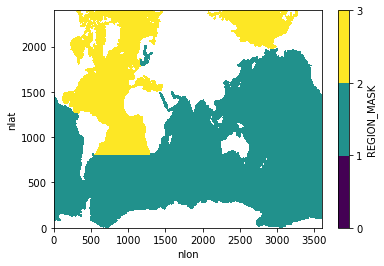

In [21]:
## Define MOC region mask with legend:
rmask = ds_g.REGION_MASK
rmasknew = rmask.where(rmask>0)
rmasknew = xr.where((rmask>0),1,rmasknew)
rmasknew = xr.where((rmask>=6) & (rmask<=11),2,rmasknew)
rmasknew.plot(levels=[0,1,2,3]);
rmasknew.attrs['legend'] = {0:"Global",1:"IndoPac+SO",2:"Atlantic"}

### Compute MOC

#### Compute Zonal Integral of vertical flux

In [22]:
def wflux_zonal_int(wflux,regionmask,lat):
    """ 
    Compute zonally-integrated vertical volume flux for each subdomain 
    defined by regionmask, using lat as the target latitude grid.
    """
    rmaskdict = regionmask.legend
    regions=xr.DataArray(list(rmaskdict.values()),dims=["transport_reg"],name="transport_reg")
    regionvals = list(rmaskdict.keys())
    ny = len(lat)
    field_lat = wflux.TLAT.data
    xrlist_all = []
    for key in rmaskdict:
        region = rmaskdict[key]
        xrlist = [wflux.sum(['nlon','nlat'])*0.]
        for i in range(ny-1):
            if (region=='Global'):
                latstrip = (field_lat>=lat.data[i]) & (field_lat<lat.data[i+1]) & (regionmask.data>key)
            else:
                latstrip = (field_lat>=lat.data[i]) & (field_lat<lat.data[i+1]) & (regionmask.data==key)
            xrlist.append(wflux.where(latstrip).sum(['nlon','nlat']))
        xrlist_all.append(xr.concat(xrlist,lat))
    xr_out = xr.concat(xrlist_all,regions).transpose("time","transport_reg","z_w_top",...)
    return xr_out 

In [23]:
%%time
wflux_zonint = wflux_zonal_int(wflux,rmasknew,ds_t.lat_aux_grid)

CPU times: user 55.4 s, sys: 2.06 s, total: 57.5 s
Wall time: 59.8 s


In [25]:
wflux_zonint = wflux_zonint.load()

KeyboardInterrupt: 

#### Compute Meridional Cumulative Sum

In [13]:
%%time
MOC = wflux_zonint.cumsum(dim='lat_aux_grid')/1.e6
MOC = MOC

CPU times: user 283 ms, sys: 4.96 ms, total: 288 ms
Wall time: 305 ms


In [14]:
MOC

,Array,Chunk
Bytes,27.34 MiB,496 B
Shape,"(48, 3, 63, 395)","(1, 1, 62, 1)"
Count,7183920 Tasks,113760 Chunks
Type,float64,numpy.ndarray


In [27]:
%%time
fdir = '/glade/scratch/whokim/archive/g.e21.GRYF_0304.TL319_t13.003/ocn/proc/tseries/annual/'
fout = fdir + 'g.e21.GRYF_0304.TL319_t13.003.pop.MOC.0001-0037.nc'

out_ds = MOC.to_dataset(name='MOC')
out_ds.lat_aux_grid.encoding['_FillValue'] = None
out_ds.z_w_top.encoding['_FillValue'] = None
out_ds.to_netcdf(fout,unlimited_dims='time')

distributed.utils - ERROR - "('nancumsum-f0c55bffd0f5393a3dce9f05e0f04b64', 'extra', 22, 0, 1, 0)"
Traceback (most recent call last):
  File "/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/distributed/utils.py", line 665, in log_errors
    yield
  File "/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 1720, in add_worker
    typename=types[key],
KeyError: "('nancumsum-f0c55bffd0f5393a3dce9f05e0f04b64', 'extra', 22, 0, 1, 0)"
distributed.core - ERROR - "('nancumsum-f0c55bffd0f5393a3dce9f05e0f04b64', 'extra', 22, 0, 1, 0)"
Traceback (most recent call last):
  File "/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/distributed/core.py", line 411, in handle_comm
    result = await result
  File "/glade/u/home/whokim/miniconda3/envs/rapcdi-analysis/lib/python3.8/site-packages/distributed/scheduler.py", line 1720, in add_worker
    typename=types[key],
KeyError: "(

KilledWorker: ("('sum-69e2c5c9b4883beaded180ca4108809c', 5, 1, 3, 2)", <Worker 'tcp://10.12.206.32:37946', name: 15, memory: 0, processing: 15107>)

### Plot MOC

<ipython-input-22-331124d7d08a>:7: UserWarning: linewidths is ignored by contourf
  cntr1 = ax.contourf(MOC.lat_aux_grid, MOC.z_w_top/1.e5, MOC.isel(time=0,transport_reg=2),levels=mnlevs, linewidths=0.5, cmap=mycmap,extend='max')


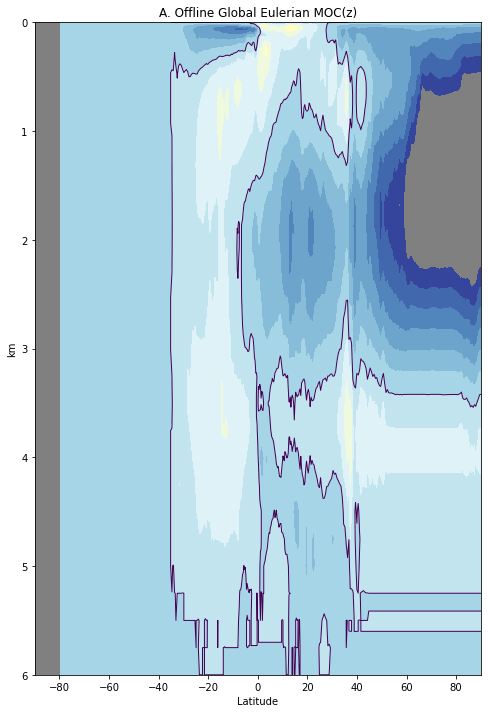

In [22]:
fig = plt.figure(figsize=(10,6))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)

ax = fig.add_subplot(1,1,1)
ax.set_title('A. Offline Global Eulerian MOC(z)')
cntr1 = ax.contourf(MOC.lat_aux_grid, MOC.z_w_top/1.e5, MOC.isel(time=0,transport_reg=2),levels=mnlevs,cmap=mycmap,extend='max')
ax.contour(MOC.lat_aux_grid, MOC.z_w_top/1.e5, MOC.isel(time=0,transport_reg=2),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')
# ax.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')

### Write to netcdf